In [1]:
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
import GPy
import itertools  # Import the itertools module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize,fmin_l_bfgs_b
from scipy.spatial import ConvexHull, Voronoi
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde

from skopt import BayesSearchCV
from skopt.space import Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C, RationalQuadratic
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Guide and Ideas for Capstone Project - Function 6

# Function 6: Cake and Stuff
Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

<a id = 'Index:'></a>

# Table of Content

In this notebook we will apply Bayesian Optimisation for Black-Box functions.


- [Part 1](#part1)- Load the data
- [Part 2](#part2)- Optimisation

[Back to top](#Index:) 

<a id='part1'></a>

### Part 1 - Load the data & perform analysis

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_6/initial_inputs.npy')
Y = np.load('initial_data/function_6/initial_outputs.npy')
print(X)
print(Y)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [5]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.7281861047460138-0.1546925696237983-0.7325516687239811-0.6939965090690888-0.0564013105182586
0.2423843472379076-0.8440999723462298-0.5778090988182423-0.6790212842838805-0.5019528879463457
0.7295226100931684-0.7481062003003915-0.6797746408949024-0.3565522793389573-0.6710536834597941
0.7706202417255450-0.1144037441632277-0.0467799318531783-0.6483242845395736-0.2735490526883131
0.6188122987341569-0.3318021371842083-0.1872878677739273-0.7562384740190410-0.3288347983365967
0.7849580941321159-0.9106823491056887-0.7081201035127033-0.9592254289504146-0.0049114958644046
0.1451107857376628-0.8966845977360148-0.8963222346125226-0.7262715366744776-0.2362719909120933
0.9450690681186655-0.2884590505951757-0.9788057635601997-0.9616555869902994-0.5980159363909763
0.1257201550301987-0.8627246921598651-0.0285443322310598-0.2466052719305282-0.7512062409044311
0.7575943553544202-0.3558314149155301-0.0165228996855636-0.4342072049866272-0.1124330443582503
0.5367969034860786-0.3087809072394933-0.4118792850

In [6]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      427   1  0.605439  0.664755       NaN       NaN       NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN       NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN       NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363       NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905       NaN   
5     1      427   6  0.464312  0.339986  0.491438  0.749695  0.159201   
6     1      427   7  0.000000  0.268289  0.446722  0.095962  0.273324   
7     1      427   8  0.088905  0.288209  0.044306  0.256810  0.634647   
8     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
9     1      428   2  0.983984  0.999998       NaN       NaN       NaN   

         X6        X7       X8            Y  
0       NaN       NaN      NaN     0.007671  
1       NaN       NaN      NaN    -0.011315  
2       NaN       NaN      NaN    -0.146375  
3

In [7]:
## need to change the function name

pw_fn = pd_new[pd_new['Fn']==6]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.

## need to add addition feature based on the dimension
X_new_points = pw_fn[['X1','X2','X3','X4','X5']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[4.64312e-01 3.39986e-01 4.91438e-01 7.49695e-01 1.59201e-01]
 [1.23000e-04 1.42857e-01 1.42857e-01 9.99998e-01 1.23000e-04]
 [2.93523e-01 3.75070e-02 4.68229e-01 7.34958e-01 8.70948e-01]
 [1.05263e-01 0.00000e+00 0.00000e+00 9.90000e-01 0.00000e+00]
 [1.39710e-02 5.47920e-02 2.92459e-01 9.75810e-01 8.96900e-03]
 [4.10940e-01 7.38891e-01 6.04170e-02 3.37090e-01 1.51347e-01]
 [1.11111e-01 2.22222e-01 2.22222e-01 0.00000e+00 0.00000e+00]
 [1.19434e-01 8.69588e-01 2.71170e-02 2.34275e-01 7.63646e-01]
 [5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01]
 [4.21053e-01 3.15789e-01 9.99000e-01 9.99990e-01 2.10526e-01]
 [9.51237e-01 1.59740e-02 9.87161e-01 9.73952e-01 1.13810e-02]
 [8.48435e-01 9.54611e-01 2.08151e-01 7.51580e-02 8.58138e-01]
 [3.00000e-01 3.00000e-01 3.00000e-01 3.00000e-01 3.00000e-01]
 [4.44444e-01 2.22222e-01 6.66666e-01 8.88888e-01 2.22222e-01]
 [6.42700e-01 8.14501e-01 3.51736e-01 3.84640e-02 3.98945e-01]
 [5.13091e-01 5.21241e-01 5.48135e-01 9.60585e-01 9.513

In [8]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[7.28186105e-01 1.54692570e-01 7.32551669e-01 6.93996509e-01
  5.64013105e-02]
 [2.42384347e-01 8.44099972e-01 5.77809099e-01 6.79021284e-01
  5.01952888e-01]
 [7.29522610e-01 7.48106200e-01 6.79774641e-01 3.56552279e-01
  6.71053683e-01]
 [7.70620242e-01 1.14403744e-01 4.67799319e-02 6.48324285e-01
  2.73549053e-01]
 [6.18812299e-01 3.31802137e-01 1.87287868e-01 7.56238474e-01
  3.28834798e-01]
 [7.84958094e-01 9.10682349e-01 7.08120104e-01 9.59225429e-01
  4.91149586e-03]
 [1.45110786e-01 8.96684598e-01 8.96322235e-01 7.26271537e-01
  2.36271991e-01]
 [9.45069068e-01 2.88459051e-01 9.78805764e-01 9.61655587e-01
  5.98015936e-01]
 [1.25720155e-01 8.62724692e-01 2.85443322e-02 2.46605272e-01
  7.51206241e-01]
 [7.57594355e-01 3.55831415e-01 1.65228997e-02 4.34207205e-01
  1.12433044e-01]
 [5.36796903e-01 3.08780907e-01 4.11879285e-01 3.88225177e-01
  5.22528304e-01]
 [9.57739669e-01 2.35668572e-01 9.91458496e-02 1.56805934e-01
  7.13173731e-02]
 [6.29307895e-01 8.03483678e-01 8.114084

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [9]:
next_query = np.random.uniform(size = 5)
print(next_query)

[0.23078411 0.56117735 0.82663117 0.03716992 0.93551734]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [10]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df['output'] = Y_updated

In [11]:
"""
# Save to CSV
csv_file_path = 'initial_data/function_6/function_6.csv'
df.to_csv(csv_file_path, index=False)

print(f"Dataset saved to '{csv_file_path}'")

"""

'\n# Save to CSV\ncsv_file_path = \'initial_data/function_6/function_6.csv\'\ndf.to_csv(csv_file_path, index=False)\n\nprint(f"Dataset saved to \'{csv_file_path}\'")\n\n'

In [12]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4         x5     output
count  46.000000  46.000000  46.000000  46.000000  46.000000  46.000000
mean    0.471994   0.462175   0.466867   0.547147   0.378905  -1.400161
std     0.296354   0.289712   0.296382   0.326824   0.312651   0.635352
min     0.000123   0.000000   0.000000   0.000000   0.000000  -2.868281
25%     0.210596   0.248866   0.211669   0.237358   0.111442  -1.700504
50%     0.444444   0.377376   0.455756   0.663673   0.314417  -1.405243
75%     0.729188   0.733073   0.676497   0.762055   0.610725  -1.099335
max     0.986382   0.954611   0.999000   0.999998   0.951333  -0.006144


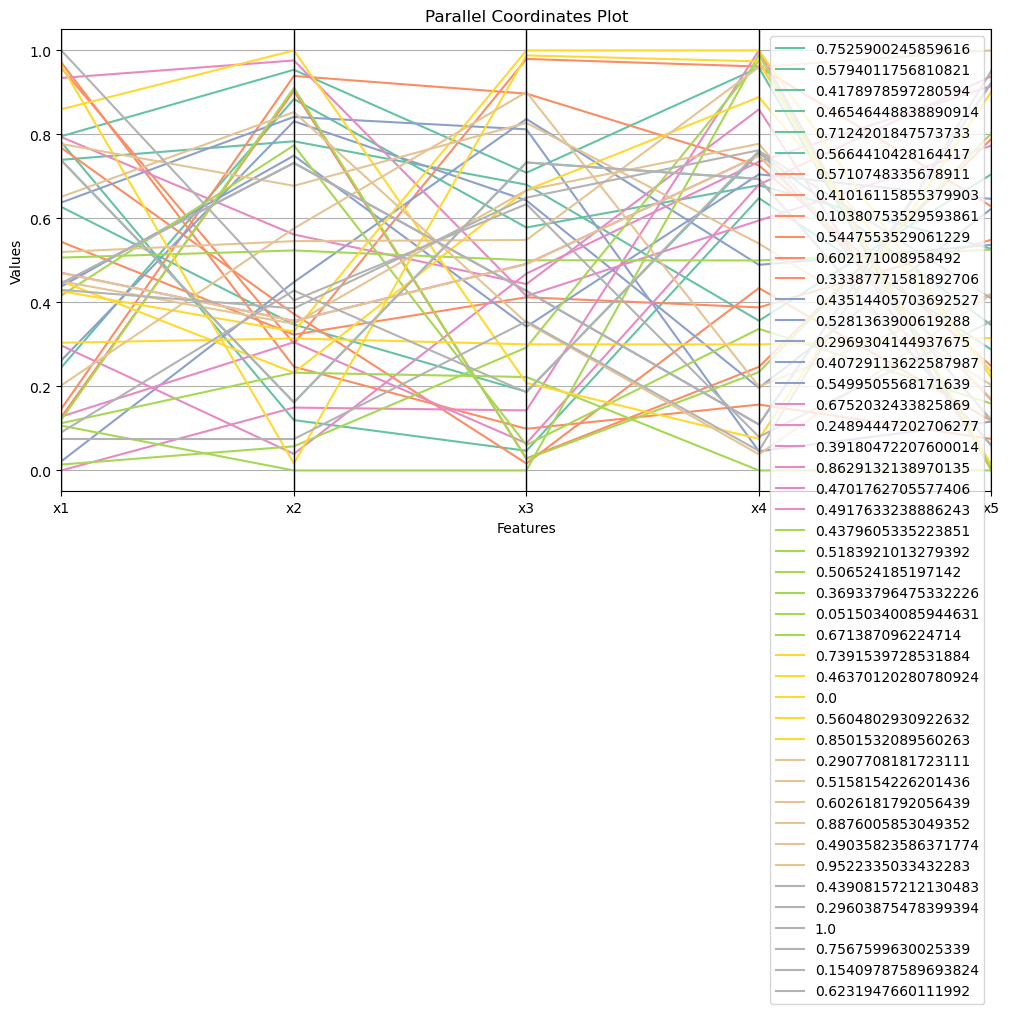

In [13]:
#Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates
# Normalize the data if necessary
df = (df - df.min()) / (df.max() - df.min())

# Create the Parallel Coordinates Plot
plt.figure(figsize=(12, 6))
parallel_coordinates(df, 'output', colormap=plt.get_cmap("Set2"))
plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

## Maximum Empty Circle or MEC in a Voronoi diagram (Convex)

In [14]:

# Replace with the datapoints
points = X_updated  

# Creating the Voronoi diagram 
vor = Voronoi(points)

# Compute Convex Hull 
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty sphere 
max_radius = 0
center_of_max_sphere = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_sphere = vertex


# You can print the results or analyze them programmatically
if center_of_max_sphere is not None:
    print(f"Center of the largest empty sphere: {format_query(center_of_max_sphere,6)}")
    print("Radius of the largest empty sphere:", max_radius)
else:
    print("No empty sphere found within the convex hull.")
    
print_timestamp()        

Center of the largest empty sphere: 0.651253-0.607453-0.718672-0.930997-0.491339
Radius of the largest empty sphere: 0.5177588408673287
Current Timestamp:  2024-02-17 15:48:56.783153


## Maximum Empty Circle or MEC in a Voronoi diagram

In [15]:

def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)


if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")
    
print_timestamp()

Center of the largest empty circle: 0.848435-0.954611-0.208151-0.075158-0.858138
Radius of the largest empty circle: 1.034013523731155
Current Timestamp:  2024-02-17 15:48:59.029992


## The best point is [0.848435, 0.954611, 0.208151, 0.075158, 0.858138]


In [16]:
# updated dataset
points = X_updated

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates
best_points = [0.848435, 0.954611, 0.208151, 0.075158, 0.858138]  

# Define the threshold for each dimension
threshold = 0.2  # Example threshold value

# Calculate min and max values for each dimension based on the threshold
min_values = [x - threshold for x in best_points]
max_values = [x + threshold for x in best_points]

# Increase the number of samples significantly
num_samples = 100000  # Larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region.")

# The target point 
target_point = np.array(best_points)

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to", best_points, "are:")
print(closest_points)

print_timestamp()

The 10 closest points to [0.848435, 0.954611, 0.208151, 0.075158, 0.858138] are:
[[0.7873121  0.94295304 0.19254966 0.07629175 0.92497163]
 [0.81836064 0.97214182 0.29586237 0.10236756 0.88131219]
 [0.80668695 0.93542017 0.20253602 0.16620512 0.83641877]
 [0.80455668 0.95066098 0.18191323 0.11385086 0.77451286]
 [0.91136237 0.89723617 0.22192212 0.12910115 0.82977907]
 [0.93251783 0.9987759  0.18896742 0.12732948 0.88627521]
 [0.87830709 0.94345999 0.12565387 0.02166788 0.805907  ]
 [0.76963005 0.9707508  0.14839524 0.04365316 0.80782705]
 [0.79185918 0.93292993 0.12095789 0.11022945 0.90219524]
 [0.74800021 0.90675386 0.24543981 0.08358787 0.83020509]]
Current Timestamp:  2024-02-17 15:49:01.765640


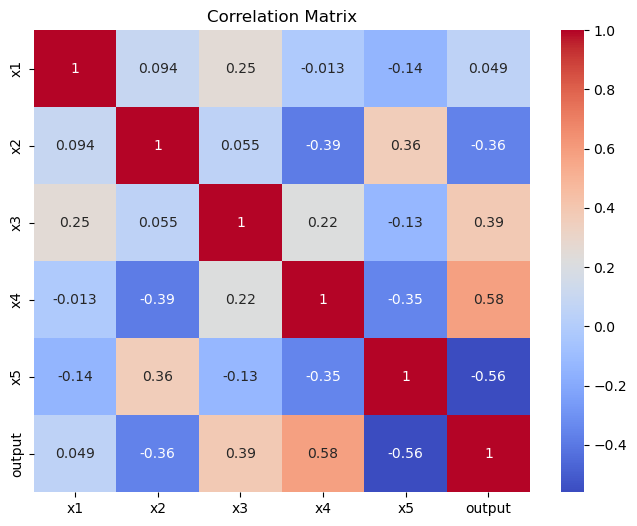

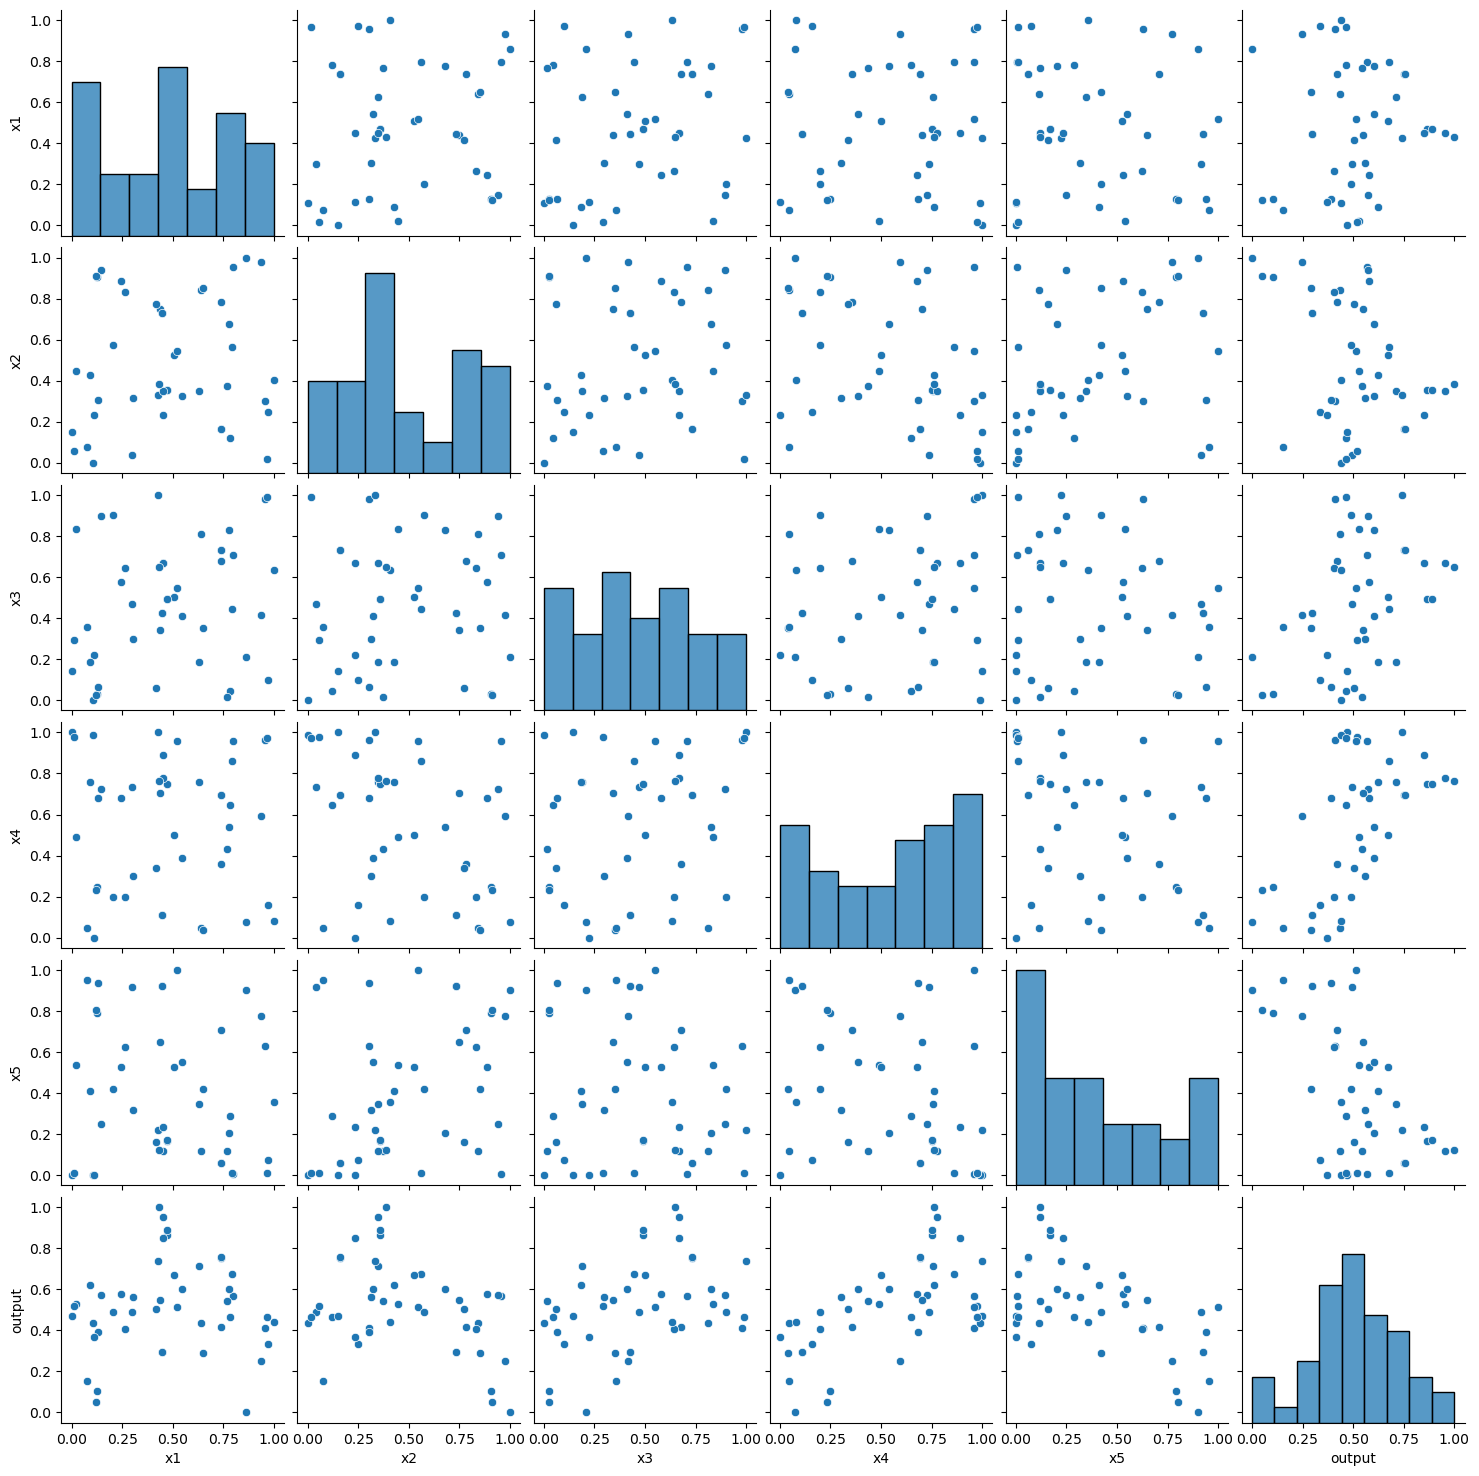

In [17]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

[Back to top](#Index:) 

<a id='part2'></a>

### Part 2 - Optimisation

In [18]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)

print("Kappa Array:")
for index, value in enumerate(kappa_array):
    print(f"Week {index+1}(Index {index}): {value}")

print("Xi Array:")
for index, value in enumerate(xi_array):
    print(f"Week {index +1}(Index {index}): {value}")

Kappa Array:
Week 1(Index 0): 1.96
Week 2(Index 1): 1.764
Week 3(Index 2): 1.5876000000000001
Week 4(Index 3): 1.42884
Week 5(Index 4): 1.285956
Week 6(Index 5): 1.1573604000000002
Week 7(Index 6): 1.0416243600000001
Week 8(Index 7): 0.9374619240000002
Week 9(Index 8): 0.8437157316000001
Week 10(Index 9): 0.7593441584400001
Xi Array:
Week 1(Index 0): 0.1
Week 2(Index 1): 0.09000000000000001
Week 3(Index 2): 0.08100000000000002
Week 4(Index 3): 0.0729
Week 5(Index 4): 0.06561
Week 6(Index 5): 0.05904900000000001
Week 7(Index 6): 0.05314410000000001
Week 8(Index 7): 0.04782969000000001
Week 9(Index 8): 0.04304672100000001
Week 10(Index 9): 0.03874204890000001


In [19]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [20]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma

In [21]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

In [22]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

# Approach 2: Surrogate - using sklearn GP model train accumulatively & RandomisedSearchCV for hyperparameter optimisation

dict_keys(['k1', 'k2', 'k1__k1', 'k1__k2', 'k1__k1__constant_value', 'k1__k1__constant_value_bounds', 'k1__k2__length_scale', 'k1__k2__length_scale_bounds', 'k2__noise_level', 'k2__noise_level_bounds'])
Best Parameters: {'kernel__k1__k1__constant_value': 0.5450293694558251, 'kernel__k1__k2__length_scale': 5.141096648805749, 'kernel__k2__noise_level': 0.000996251322205511}
Log-marginal-likelihood: -14.859419510640222
MSE: 0.0032953938821608953
R-squared: 0.9937968315060404


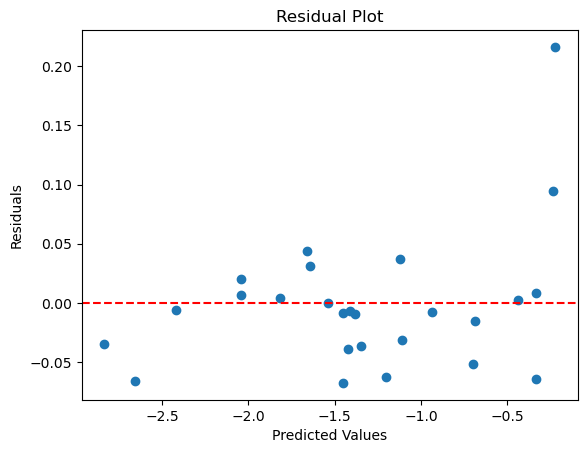

Current Timestamp:  2024-02-17 15:49:27.327312


In [23]:

#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.

# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min

param_distributions = {
    'kernel__k1__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k1__k2__length_scale': loguniform(1e-4, 1e2),
    'kernel__k2__noise_level': loguniform(1e-4, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e1))
# Print the parameter names
print(kernel.get_params().keys())

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer) 


random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')


print_timestamp()

# Approach 2 sklearn: train accumulatively & BayesSearchCV for hyperparameter optimisation

In [25]:
# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min

param_distributions = {
    'kernel__k1__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k1__k2__length_scale': loguniform(1e-4, 1e2),
    'kernel__k2__noise_level': loguniform(1e-4, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e1))
# Print the parameter names
print(kernel.get_params().keys())

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer)

# Define the search space for the hyperparameters
search_spaces = {
    'kernel__k1__k1__constant_value': Real(1e-4, 1e5, prior='log-uniform'),
    'kernel__k1__k2__length_scale': Real(1e-5, 1e3, prior='log-uniform'),
    'kernel__k2__noise_level': Real(1e-10, 1e11, prior='log-uniform')
}

# Instantiate BayesSearchCV
bayes_search = BayesSearchCV(gp, search_spaces, n_iter=10, cv=10, random_state=42, n_jobs=-1)

# Fit the model
bayes_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = bayes_search.best_estimator_
best_params = bayes_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')

print_timestamp()

Best Parameters: OrderedDict([('kernel__k1__constant_value', 2.224459696801683), ('kernel__k2__length_scale', 229.1257035436645)])
Log-marginal-likelihood: -169.60404001589072
Current Timestamp:  2024-02-11 20:37:09.697371


 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.


## Approach 2 sklearn: train accumulatively - different kernel with better log value¶

In [26]:
# Define a custom optimizer function with increased max_iter
def custom_optimizer(obj_func, initial_theta, bounds):
    # Optimize using the L-BFGS-B algorithm
    opt_results = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, maxfun=1000, maxiter=20000)
    
    # Unpack the first two values (optimized parameters and function minimum)
    theta_opt, func_min = opt_results[:2]
    
    return theta_opt, func_min


kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e1))
# Print the parameter names
print(kernel.get_params().keys())

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, optimizer=custom_optimizer)

# Define parameter grid with fixed values
param_grid = {
    'kernel': [
        C(constant_value) * RationalQuadratic(alpha=alpha, length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        for constant_value in np.logspace(-3, 7, num=7)  # Example range for constant_value
        for alpha in np.logspace(-2, 2, num=7)          # Example range for alpha
        for length_scale in np.logspace(-2, 2, num=7)   # Example range for length_scale
        for noise_level in np.logspace(-6, 1, num=7)    # Example fixed values for noise_level
    ]
}

grid_search = GridSearchCV(gp, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_updated, Y_updated)

# Retrieve the best model and parameters
best_gp = grid_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')

print_timestamp()

Best Parameters: {'kernel__k1__constant_value': 0.0022310108018679217, 'kernel__k2__length_scale': 15.741890047456636}
Log-marginal-likelihood: -2.4488617900408656
Current Timestamp:  2024-02-11 20:57:10.863917


## Appoach 2: using sklearn GP model via random generated grid

In [24]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 5  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 5  # For week 6, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.649451-0.392498-0.202138-0.568650-0.017763
Next query PI:  0.360709-0.436282-0.645442-0.746286-0.000356
Next query UCB:  0.336797-0.444080-0.664589-0.726275-0.001305
Current Timestamp:  2024-02-17 15:56:42.788268


## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

In [25]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 5  # For week 6, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

#mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.917165-0.824477-0.200298-0.012803-0.814110
Next query PI:  0.980716-0.765722-0.013366-0.123930-0.705998
Next query UCB:  0.785999-0.774413-0.406635-0.147759-0.696462
Current Timestamp:  2024-02-17 15:56:50.078886


## Aproach 3:  a Sparse Gaussian Process model

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |               value  |  constraints  |  priors
  variance     |    9.78997680867962  |      +ve      |        
  lengthscale  |  1.9911225997027198  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.06458816  |      +ve      |        
MSE on validation set: 0.9049897576248327
MSE: 0.03707447765350718
R-squared: 0.930211913982361


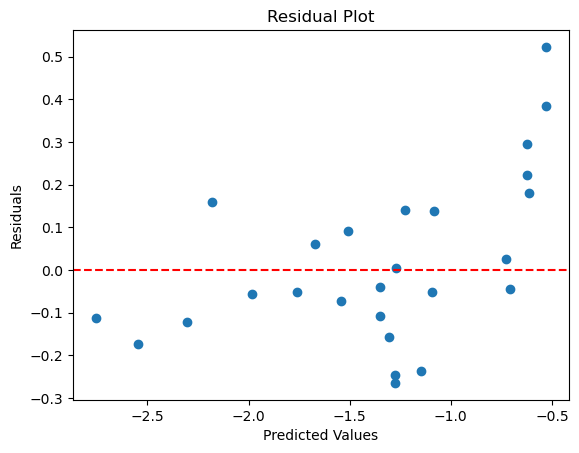

Current Timestamp:  2024-02-17 15:56:55.881441


In [26]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')

print_timestamp()

In [27]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

#mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

Next query EI:  0.094217-0.270830-0.998492-0.987771-0.000174
Next query PI:  0.094217-0.270830-0.998492-0.987771-0.000174
Next query UCB:  0.179006-0.477552-0.945044-0.986959-0.001812
Current Timestamp:  2024-02-17 15:57:14.068057


[Back to top](#Index:) 